## TRAIT AND TROPOMI

In [20]:
import xarray as xr
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Polygon
from scipy.stats import pearsonr
import geopandas as gpd
import sys
from mpl_toolkits.basemap import Basemap
import pyproj
from pyproj import Proj, transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

import scipy.stats as st 


# Define the source and target CRS
src_crs = Proj('EPSG:4326')
target_crs = Proj(proj='latlong', datum='WGS84')

# Now, use lon_values_reprojected and lat_values_reprojected in your plt.imshow() and shapefile plotting functions

# Load the shapefile using geopandas
shapefile_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/dangermond_bound/dan_bound2.shp"
gdf = gpd.read_file(shapefile_path)
#gdf = gdf.to_crs('EPSG:2229')
#gdf = gdf.to_crs('EPSG:4326')

#shape_values = gdf.values

#print(shape_values)

#sys.exit()

#stateshp = gpd.read_file('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/dangermond_bound/dan_bound.shp')
#print stateshp1.crs
# Reproject to EPSG:4326
#stateshp = stateshp.to_crs(epsg=4326)
#stateshp.to_file('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/dangermond_bound/dan_bound1.shp', driver='ESRI Shapefile')

#sys.exit()
# Print the information about the shapefile
#print(gdf.info())

# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file path
base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax_fixed_regridded.nc"

# Open the NetCDF file for TROPOMI dataset
file2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.001deg_regrid_Dangermond_tll_clipped.nc"
ds2 = xr.open_dataset(file2, decode_times=True)

# Save dates, mean, and std values to a text file
try:
    file = open('trait_statistics_lr_jmax.txt', 'w')
    file.write('Date\tMean Observed\tStd Observed\tCI95 Observed\tMean Predicted\tStd Predicted\tCI95 Predicted\n')
except Exception as e:
    print(f"Error: {e}")


# Initialize empty lists to accumulate data points
observed_all = []
predicted_all = []

# Initialize a list to store individual spatial differences
spatial_diff_list = []

for i, target_date_str in enumerate(dates):
    # Construct file1 dynamically based on the time step index (i)
    file1 = base_file_path.format(str(i).zfill(2))

    # Open dataset for file1
    ds1 = xr.open_dataset(file1, decode_times=False)  
    
    target_date = pd.Timestamp(target_date_str).value / 10**9  # Convert to seconds since epoch
    print('target_date=',target_date)
    # Convert target_date to datetime64[ns]
    target_date = pd.to_datetime(target_date, unit='s')
    print('target_date=',target_date)

    # Define a time range for a week centered around the target date
    start_date = target_date - pd.Timedelta(days=6)  # 3 days before the target date
    end_date = target_date + pd.Timedelta(days=6)    # 3 days after the target date

    # Select the data from the dataset with multiple times based on the specific date
    ds2_selected = ds2.sel(time=target_date, method="nearest")
    print(ds2_selected)
    
    # Select the data from ds2 within the specified time range
    ds2_selected = ds2.sel(time=slice(start_date, end_date))
    ds2_selected = ds2_selected.mean(dim='time', skipna=True)
    print(ds2_selected)
    #sys.exit()

    # Calculate the average time of the selected data in ds2_selected

    ds1_selected = ds1['sif740']
    
    # Filter out NaN values
    valid_indices = ~np.isnan(ds2_selected['sif'].values.flatten()) & ~np.isnan(ds1_selected.values.flatten())
    if valid_indices.any():
        observed = ds2_selected['sif'].values.flatten()[valid_indices]
        predicted = ds1_selected.values.flatten()[valid_indices]
        
        print("Observed shape before cleaning:", observed.shape)
        print("Predicted shape before cleaning:", predicted.shape)

        observed = observed[~np.isnan(observed)]
        predicted = predicted[~np.isnan(predicted)]

        print("Observed shape after cleaning:", observed.shape)
        print("Predicted shape after cleaning:", predicted.shape)


        print('mean obs =', np.mean(observed))
        print('mean pred =', np.mean(predicted))

        # Calculate spatial differences
        spatial_diff_num =  predicted - observed 

        # Squeeze the array to remove the singleton dimension
        spatial_diff_num = np.squeeze(spatial_diff_num)   
        
        # Calculate spatial differences
        spatial_diff =  ds1_selected.values - ds2_selected['sif'].values
        
        # Squeeze the array to remove the singleton dimension
        spatial_diff = np.squeeze(spatial_diff)
        
        
        # Calculate spatial differences and append them to the list
        spatial_diff_list.append(spatial_diff)

        #Get latitude and longitude values
        lat_values = ds2_selected['lat'].values
        lon_values = ds2_selected['lon'].values
        
        # Calculate metrics
        mae = mean_absolute_error(observed, predicted)

        # Calculate mean, std, bias, RMSE, and R²
        mean_observed = np.mean(observed)
        mean_predicted = np.mean(predicted)
        std_observed = np.std(observed)
        std_predicted = np.std(predicted)
        bias = mean_predicted - mean_observed
        rmse = np.sqrt(np.mean((predicted - observed)**2))
        slope, intercept, r_value, p_value, std_err = linregress(observed, predicted)
        r2 = r_value**2


        
        #plt.imshow(spatial_diff)
        #plt.colorbar()
        #plt.show()
        #plt.close()
        print("mae:", mae)
        print("bias:", bias)
        print("RMSE:", rmse)
        print("R^2 Score:", r2)

        # create 95% confidence interval 
        ci95_observed = st.t.interval(0.95, df=len(observed)-1, 
                        loc=np.mean(observed), 
                        scale=st.sem(observed)) 

        # create 95% confidence interval 
        ci95_predicted = st.t.interval(0.95, df=len(predicted)-1, 
                        loc=np.mean(predicted), 
                        scale=st.sem(predicted)) 
        
        # Extracting low and high values from the confidence intervals
        ci95_observed_low, ci95_observed_high = ci95_observed
        ci95_predicted_low, ci95_predicted_high = ci95_predicted
  
        # Append statistics for the current date to the file
        #file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted}\t{bias}\t{rmse}\t{r2}\n')
        # Improved format:
        file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed_low}\t{ci95_observed_high}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted_low}\t{ci95_predicted_high}\t{bias}\t{rmse}\t{r2}\n')


        # Create a Basemap instance with the desired projection
        m = Basemap(projection='merc', llcrnrlat=lat_values.min(), urcrnrlat=lat_values.max(),
                llcrnrlon=lon_values.min(), urcrnrlon=lon_values.max(), resolution='c')

        x,y = np.meshgrid(lon_values, lat_values) 
        X,Y = m(x, y)
        
        # Define the number of decimal places for meridian and parallel labels
        decimal_places = 3

        # Define a custom formatter function to format the labels with the specified number of decimal places
        def format_labels(x, pos):
            return '{:.{decimal_places}f}'.format(x, decimal_places=decimal_places)


        # Create a figure and axes
        plt.figure(figsize=(8, 6))
        m.drawparallels(np.arange(-90.,91.,0.025), labels=[1,0,0,1],    dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        m.drawmeridians(np.arange(0., 360., 0.025), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        #m.drawcoastlines(color='0.6', linewidth=0.5)

        # Plot spatial differences using pcolormesh with Basemap
        cs = m.pcolormesh(X, Y, spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)

        vmin = -1
        vmax = 1
        cbar = m.colorbar(cs, pad='10%',ticks=np.linspace(vmin,vmax,7),format='%.2f')
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel(r'SIF$_{740nm}$ difference (W.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', rotation=270, verticalalignment='center', color='black', size=16)
        cbar.solids.set_edgecolor("face")
        #cbar.set_clim(vmin,vmax)
        # Assuming cbar is your Colorbar object
        #cbar.ax.set_clim(vmin, vmax)
        cbar.ax.tick_params(labelsize='large')
        #gdf.plot(ax=m, linewidth=1, edgecolor='black', facecolor='none', legend=True)
        #m.readshapefile(shapefile_path,'Geometry')
        # Plot contour of Dangermond shapefile
        #m.readshapefile(shapefile_path, 'dan_bound2', linewidth=2, color='black')
        
        # Manually draw shapefile polygons on top of the contour plot
        for shape in gdf['geometry']:
            if shape.geom_type == 'Polygon':
                x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
                polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
                plt.gca().add_patch(polygon)

        # Plot spatial differences with latitude and longitude values on the y and x axes
        #plt.imshow(spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data range
    
        # Overlay shapefile contour on top of the spatial differences plot
        #gdf.plot(ax=plt.gca(), linewidth=1, edgecolor='black', facecolor='none', legend=True)


        # Set title, labels, and tick formatters
        plt.title(f'Spatial Differences at {target_date_str}',fontsize=14)
        #plt.xlabel('Longitude')
        #plt.ylabel('Latitude')
    

        # Add colorbar to the right of the plot
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.1)


        
        # Set 2 decimal places for latitude and longitude ticks
        #lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lat_values[x]))
        #lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lon_values[x]))
        
        
        # Get latitude and longitude values from your SIF data
        #lat_min, lat_max = lat_values.min(), lat_values.max()
        #lon_min, lon_max = lon_values.min(), lon_values.max()
        #print( lon_min, lon_max,lat_min, lat_max)
        
        # Set 4 ticks for latitude and longitude
        #num_ticks = 4
        #lat_indices = np.linspace(0, len(lat_values) - 1, num_ticks, dtype=int)
        #lon_indices = np.linspace(0, len(lon_values) - 1, num_ticks, dtype=int)

        # Set x and y ticks with actual lat and lon values formatted to 2 decimal places
        #plt.xticks(lon_indices, lon_values[lon_indices])
        #plt.yticks(lat_indices, lat_values[lat_indices])

        # Set formatted latitude and longitude tick labels
        #plt.gca().get_xaxis().set_major_formatter(lon_formatter)
        #plt.gca().get_yaxis().set_major_formatter(lat_formatter)
        


        # Add text box with statistics in the upper right corner
        bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
        plt.gca().text(0.95, 0.95, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}',
                transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right',fontsize=14)
                


        # Invert the latitude axis
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        # Save the figure
        plt.savefig(f'spatial_differences_{i}_lr_jmax.png',dpi=300)
        #plt.show()
        #sys.exit()
        
        # Close the figure to avoid displaying multiple plots at once
        plt.close()
        print('Figure spatial_differences_{i}.png saved!')
        

        # Filter out NaN values
        valid_indices = ~np.isnan(ds1_selected.values) & ~np.isnan(ds2_selected['sif'].values)
        observed = ds2_selected['sif'].values.reshape(-1)[valid_indices.reshape(-1)]
        predicted = ds1_selected.values.reshape(-1)[valid_indices.reshape(-1)]

        # Check if there are still valid values after filtering
        if len(observed) > 0 and len(predicted) > 0:
            # Accumulate observed and predicted values
            observed_all.extend(observed)
            predicted_all.extend(predicted)

        # Close the datasets to free up resources
        ds1.close()
        ds2_selected.close()
        
        print('Total matrix ammended!')
        print(spatial_diff_list)
    
    
# Calculate the average spatial difference after the loop
average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)  

# Create a figure and axes
plt.figure(figsize=(8, 6))
m.drawparallels(np.arange(-90., 91., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)
m.drawmeridians(np.arange(0., 360., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)

# Plot spatial differences using pcolormesh with Basemap
cs = m.pcolormesh(X, Y, average_spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)

vmin = -1
vmax = 1
cbar = m.colorbar(cs, pad='10%', ticks=np.linspace(vmin, vmax, 7), format='%.2f')
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel(r'SIF$_{740nm}$ difference (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', rotation=270, verticalalignment='center', color='black', size=16)
cbar.solids.set_edgecolor("face")
cbar.ax.tick_params(labelsize='large')

# Manually draw shapefile polygons on top of the contour plot
for shape in gdf['geometry']:
    if shape.geom_type == 'Polygon':
       x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
       polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
       plt.gca().add_patch(polygon)

# Set title, labels, and tick formatters
plt.title(f'Mean Spatial Difference', fontsize=14)

# Add text box with statistics in the upper right corner
bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
plt.gca().text(0.95, 0.95, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}',
           transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right', fontsize=14)


plt.tight_layout()
# Save the figure
plt.savefig(f'spatial_differences_mean_lr_jmax.png', dpi=300)


# Close the figure to avoid displaying multiple plots at once
plt.close()
print(f'Figure pft_spatial_differences_{i}.png saved!')
  
# Calculate mean absolute difference and R^2 score for all accumulated data points
mean_abs_diff = np.mean(np.abs(np.array(predicted_all) - np.array(observed_all)))
#r2 = r2_score(np.array(observed_all), np.array(predicted_all))
# Calculate Pearson correlation coefficient
pearson_corr, _ = pearsonr(np.array(observed_all), np.array(predicted_all))

# Calculate R^2
r2 = pearson_corr**2

print("Mean Absolute Difference:", mean_abs_diff)
print("R^2 Score:", r2)

# Create a scatter plot for all accumulated data points
plt.figure(figsize=(8, 6))
plt.scatter(observed_all, predicted_all, color='blue', label='Observed vs Predicted')
plt.plot(observed_all, observed_all, color='red', linestyle='--', label='Perfect Fit')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_all, predicted_all)

# Assuming observed_all is a list
observed_all = np.array(observed_all)
predicted_all = np.array(predicted_all)

# Calculate fitted values using the regression equation
fitted_values = intercept + slope * observed_all

# Calculate MAE, bias, RMSE, and R²
mae = mean_absolute_error(observed_all, predicted_all)
bias = np.mean(predicted_all - observed_all)
rmse = np.sqrt(np.mean((predicted_all - observed_all)**2))
r2 = r_value**2

# Fit the linear regression model using statsmodels for AIC and BIC
X = sm.add_constant(observed_all)  # Add a constant term to the predictor
model = sm.OLS(predicted_all, X).fit()

# Get AIC and BIC
aic = model.aic
bic = model.bic

print(aic,bic)

# Plot the regression line
plt.plot(observed_all, fitted_values, color='green', label='Fitted Line')

# Display bias, RMSE, and R² on the plot
plt.text(0.1, 0.9, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}\nAIC: {aic:.2f}\nBIC: {bic:.2f}', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8'))

print(f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}\nAIC: {aic:.2f}\nBIC: {bic:.2f}')

plt.title('Observed vs Predicted SIF Values')
plt.xlabel('Observed SIF')
plt.ylabel('Predicted SIF')
plt.legend()
plt.grid(True)
plt.savefig(f'scatter_plot_all_trait_lr.png')
plt.close()

predicted_all_trait = predicted_all
observed_all_trait = observed_all

file.close()




target_date= 1645660800.0
target_date= 2022-02-24 00:00:00
<xarray.Dataset> Size: 8kB
Dimensions:         (lat: 14, lon: 17)
Coordinates:
  * lat             (lat) float32 56B 34.45 34.46 34.47 ... 34.56 34.57 34.58
  * lon             (lon) float32 68B -120.5 -120.5 -120.5 ... -120.4 -120.3
    time            datetime64[ns] 8B 2022-02-24
Data variables:
    spatial_ref     int64 8B ...
    sif             (lat, lon) float32 952B ...
    sif_sigma       (lat, lon) float32 952B ...
    cloud_fraction  (lat, lon) float32 952B ...
    sif_relative    (lat, lon) float32 952B ...
    dcCorr          (lat, lon) float32 952B ...
    phase_angle     (lat, lon) float32 952B ...
    sif_dc          (lat, lon) float32 952B ...
    n               (lat, lon) float32 952B ...
Attributes:
    title:        Awesome gridded file
    spatial_ref:  EPSG:4326
    history:      Thu Oct  5 18:05:03 2023: ncpdq -a time,lat,lon TROPOMI_SIF...
    NCO:          netCDF Operators version 5.1.7 (Homepage = http

/tmp/ipykernel_3129747/3383828300.py:325: RuntimeWarning: Mean of empty slice
  average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)


Figure pft_spatial_differences_12.png saved!
Mean Absolute Difference: 0.32888019409543595
R^2 Score: 0.16879469269985878
477.9689463878708 487.8532597992697
Bias: -0.16
RMSE: 0.40
R²: 0.17
MAE: 0.33
AIC: 477.97
BIC: 487.85


## PFT and TROPOMI

In [22]:
import xarray as xr
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Polygon
from scipy.stats import pearsonr
import geopandas as gpd
import sys
from mpl_toolkits.basemap import Basemap
import pyproj
from pyproj import Proj, transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

import scipy.stats as st 


# Define the source and target CRS
src_crs = Proj('EPSG:4326')
target_crs = Proj(proj='latlong', datum='WGS84')

# Now, use lon_values_reprojected and lat_values_reprojected in your plt.imshow() and shapefile plotting functions

# Load the shapefile using geopandas
shapefile_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/dangermond_bound/dan_bound2.shp"
gdf = gpd.read_file(shapefile_path)
#gdf = gdf.to_crs('EPSG:2229')
#gdf = gdf.to_crs('EPSG:4326')

#shape_values = gdf.values

#print(shape_values)

#sys.exit()

#stateshp = gpd.read_file('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/dangermond_bound/dan_bound.shp')
#print stateshp1.crs
# Reproject to EPSG:4326
#stateshp = stateshp.to_crs(epsg=4326)
#stateshp.to_file('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/dangermond_bound/dan_bound1.shp', driver='ESRI Shapefile')

#sys.exit()
# Print the information about the shapefile
#print(gdf.info())

# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file path
base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/pft_shift_fluxes_day_{}_jmax_fixed_regridded.nc"

base_file_path_filter = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax_fixed_regridded.nc"

# Open the NetCDF file for TROPOMI dataset
file2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.001deg_regrid_Dangermond_tll_clipped.nc"
ds2 = xr.open_dataset(file2, decode_times=True)


# Save dates, mean, and std values to a text file
try:
    file = open('pft_statistics_lr_jmax.txt', 'w')
    file.write('Date\tMean Observed\tStd Observed\tCI95 Observed\tMean Predicted\tStd Predicted\tCI95 Predicted\n')
except Exception as e:
    print(f"Error: {e}")


# Initialize empty lists to accumulate data points
observed_all = []
predicted_all = []

# Initialize a list to store individual spatial differences
spatial_diff_list = []

for i, target_date_str in enumerate(dates):
    # Construct file1 dynamically based on the time step index (i)
    file1 = base_file_path.format(str(i).zfill(2))
    file0 = base_file_path_filter.format(str(i).zfill(2))

    # Open dataset for file1
    ds1 = xr.open_dataset(file1, decode_times=False)
    ds0 = xr.open_dataset(file0, decode_times=False)   
    
    target_date = pd.Timestamp(target_date_str).value / 10**9  # Convert to seconds since epoch
    print('target_date=',target_date)
    # Convert target_date to datetime64[ns]
    target_date = pd.to_datetime(target_date, unit='s')
    print('target_date=',target_date)


    # Define a time range for a week centered around the target date
    start_date = target_date - pd.Timedelta(days=6)  # 3 days before the target date
    end_date = target_date + pd.Timedelta(days=6)    # 3 days after the target date

    # Select the data from the dataset with multiple times based on the specific date
    #ds2_selected = ds2.sel(time=target_date, method="nearest")

    # Select the data from ds2 within the specified time range
    ds2_selected = ds2.sel(time=slice(start_date, end_date))
    ds2_selected = ds2_selected.mean(dim='time', skipna=True)
    print(ds2_selected)




    ds1_selected = ds1['sif740']
    ds0_selected = ds0['sif740']

    ds1_selected.values = ds1_selected.values*(ds0_selected.values/ds0_selected.values)


    
    # Filter out NaN values
    valid_indices = ~np.isnan(ds2_selected['sif'].values.flatten()) & ~np.isnan(ds1_selected.values.flatten())
    if valid_indices.any():
        observed = ds2_selected['sif'].values.flatten()[valid_indices]
        predicted = ds1_selected.values.flatten()[valid_indices]
        
        print("Observed shape before cleaning:", observed.shape)
        print("Predicted shape before cleaning:", predicted.shape)

        observed = observed[~np.isnan(observed)]
        predicted = predicted[~np.isnan(predicted)]

        print("Observed shape after cleaning:", observed.shape)
        print("Predicted shape after cleaning:", predicted.shape)


        print('mean obs =', np.mean(observed))
        print('mean pred =', np.mean(predicted))
        

        # Calculate mean, std, bias, RMSE, and R²
        mean_observed = np.mean(observed)
        mean_predicted = np.mean(predicted)
        std_observed = np.std(observed)
        std_predicted = np.std(predicted)
        bias = mean_predicted - mean_observed
        rmse = np.sqrt(np.mean((predicted - observed)**2))
        slope, intercept, r_value, p_value, std_err = linregress(observed, predicted)
        r2 = r_value**2



        # create 95% confidence interval 
        ci95_observed = st.t.interval(0.95, df=len(observed)-1, 
                        loc=np.mean(observed), 
                        scale=st.sem(observed)) 

        # create 95% confidence interval 
        ci95_predicted = st.t.interval(0.95, df=len(predicted)-1, 
                        loc=np.mean(predicted), 
                        scale=st.sem(predicted)) 
  
        # Extracting low and high values from the confidence intervals
        ci95_observed_low, ci95_observed_high = ci95_observed
        ci95_predicted_low, ci95_predicted_high = ci95_predicted
  
        # Append statistics for the current date to the file
        #file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted}\t{bias}\t{rmse}\t{r2}\n')
        # Improved format:
        file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed_low}\t{ci95_observed_high}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted_low}\t{ci95_predicted_high}\t{bias}\t{rmse}\t{r2}\n')

        # Calculate spatial differences
        spatial_diff_num = predicted - observed 

        # Squeeze the array to remove the singleton dimension
        spatial_diff_num = np.squeeze(spatial_diff_num)   
        
        # Calculate spatial differences
        spatial_diff =  ds1_selected.values - ds2_selected['sif'].values
        
        # Squeeze the array to remove the singleton dimension
        spatial_diff = np.squeeze(spatial_diff)
        
        
        # Calculate spatial differences and append them to the list
        spatial_diff_list.append(spatial_diff)

        #Get latitude and longitude values
        lat_values = ds2_selected['lat'].values
        lon_values = ds2_selected['lon'].values
        
        # Calculate metrics
        mae = mean_absolute_error(observed, predicted)
        bias = np.mean(spatial_diff_num)
        rmse = np.sqrt(mean_squared_error(observed, predicted))
        #r2 = r2_score(observed, predicted)
        # Calculate Pearson correlation coefficient
        pearson_corr, _ = pearsonr(observed, predicted)

        # Calculate R^2
        r2 = pearson_corr**2
        
        #plt.imshow(spatial_diff)
        #plt.colorbar()
        #plt.show()
        #plt.close()
        print("mae:", mae)
        print("bias:", bias)
        print("RMSE:", rmse)
        print("R^2 Score:", r2)

        # Create a Basemap instance with the desired projection
        m = Basemap(projection='merc', llcrnrlat=lat_values.min(), urcrnrlat=lat_values.max(),
                llcrnrlon=lon_values.min(), urcrnrlon=lon_values.max(), resolution='c')

        x,y = np.meshgrid(lon_values, lat_values) 
        X,Y = m(x, y)
        
        # Define the number of decimal places for meridian and parallel labels
        decimal_places = 3

        # Define a custom formatter function to format the labels with the specified number of decimal places
        def format_labels(x, pos):
            return '{:.{decimal_places}f}'.format(x, decimal_places=decimal_places)


        # Create a figure and axes
        plt.figure(figsize=(8, 6))
        m.drawparallels(np.arange(-90.,91.,0.025), labels=[1,0,0,1],    dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        m.drawmeridians(np.arange(0., 360., 0.025), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        #m.drawcoastlines(color='0.6', linewidth=0.5)

        # Plot spatial differences using pcolormesh with Basemap
        cs = m.pcolormesh(X, Y, spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)

        vmin = -1
        vmax = 1
        cbar = m.colorbar(cs, pad='10%',ticks=np.linspace(vmin,vmax,7),format='%.2f')
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel(r'SIF$_{740nm}$ difference (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', rotation=270, verticalalignment='center', color='black', size=16)
        cbar.solids.set_edgecolor("face")
        #cbar.set_clim(vmin,vmax)
        # Assuming cbar is your Colorbar object
        #cbar.ax.set_clim(vmin, vmax)
        cbar.ax.tick_params(labelsize='large')
        #gdf.plot(ax=m, linewidth=1, edgecolor='black', facecolor='none', legend=True)
        #m.readshapefile(shapefile_path,'Geometry')
        # Plot contour of Dangermond shapefile
        #m.readshapefile(shapefile_path, 'dan_bound2', linewidth=2, color='black')
        
        # Manually draw shapefile polygons on top of the contour plot
        for shape in gdf['geometry']:
            if shape.geom_type == 'Polygon':
                x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
                polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
                plt.gca().add_patch(polygon)

        # Plot spatial differences with latitude and longitude values on the y and x axes
        #plt.imshow(spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data range
    
        # Overlay shapefile contour on top of the spatial differences plot
        #gdf.plot(ax=plt.gca(), linewidth=1, edgecolor='black', facecolor='none', legend=True)


        # Set title, labels, and tick formatters
        plt.title(f'Spatial Differences at {target_date_str}',fontsize=14)
        #plt.xlabel('Longitude')
        #plt.ylabel('Latitude')
    

        # Add colorbar to the right of the plot
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.1)


        
        # Set 2 decimal places for latitude and longitude ticks
        #lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lat_values[x]))
        #lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lon_values[x]))
        
        
        # Get latitude and longitude values from your SIF data
        #lat_min, lat_max = lat_values.min(), lat_values.max()
        #lon_min, lon_max = lon_values.min(), lon_values.max()
        #print( lon_min, lon_max,lat_min, lat_max)
        
        # Set 4 ticks for latitude and longitude
        #num_ticks = 4
        #lat_indices = np.linspace(0, len(lat_values) - 1, num_ticks, dtype=int)
        #lon_indices = np.linspace(0, len(lon_values) - 1, num_ticks, dtype=int)

        # Set x and y ticks with actual lat and lon values formatted to 2 decimal places
        #plt.xticks(lon_indices, lon_values[lon_indices])
        #plt.yticks(lat_indices, lat_values[lat_indices])

        # Set formatted latitude and longitude tick labels
        #plt.gca().get_xaxis().set_major_formatter(lon_formatter)
        #plt.gca().get_yaxis().set_major_formatter(lat_formatter)
        


        # Add text box with statistics in the upper right corner
        bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
        plt.gca().text(0.95, 0.95, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}',
                transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right',fontsize=14)
                


        # Invert the latitude axis
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        # Save the figure
        plt.savefig(f'pft_spatial_differences_{i}_lr_jmax.png',dpi=300)
        #plt.show()
        #sys.exit()
        
        # Close the figure to avoid displaying multiple plots at once
        plt.close()
        print('Figure spatial_differences_{i}.png saved!')
        

        # Filter out NaN values
        valid_indices = ~np.isnan(ds1_selected.values) & ~np.isnan(ds2_selected['sif'].values)
        observed = ds2_selected['sif'].values.reshape(-1)[valid_indices.reshape(-1)]
        predicted = ds1_selected.values.reshape(-1)[valid_indices.reshape(-1)]

        # Check if there are still valid values after filtering
        if len(observed) > 0 and len(predicted) > 0:
            # Accumulate observed and predicted values
            observed_all.extend(observed)
            predicted_all.extend(predicted)

        # Close the datasets to free up resources
        ds1.close()
        ds2_selected.close()
        
        print('Total matrix ammended!')
    
    
# Calculate the average spatial difference after the loop
average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)  

# Create a figure and axes
plt.figure(figsize=(8, 6))
m.drawparallels(np.arange(-90., 91., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)
m.drawmeridians(np.arange(0., 360., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)

# Plot spatial differences using pcolormesh with Basemap
cs = m.pcolormesh(X, Y, average_spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)

vmin = -1
vmax = 1
cbar = m.colorbar(cs, pad='10%', ticks=np.linspace(vmin, vmax, 7), format='%.2f')
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel(r'SIF$_{740nm}$ difference (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', rotation=270, verticalalignment='center', color='black', size=16)
cbar.solids.set_edgecolor("face")
cbar.ax.tick_params(labelsize='large')

# Manually draw shapefile polygons on top of the contour plot
for shape in gdf['geometry']:
    if shape.geom_type == 'Polygon':
       x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
       polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
       plt.gca().add_patch(polygon)

# Set title, labels, and tick formatters
plt.title(f'Mean Spatial Difference', fontsize=14)

# Add text box with statistics in the upper right corner
bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
plt.gca().text(0.95, 0.95, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}',
           transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right', fontsize=14)


plt.tight_layout()
# Save the figure
plt.savefig(f'pft_spatial_differences_mean_lr_jmax.png', dpi=300)


# Close the figure to avoid displaying multiple plots at once
plt.close()
print(f'Figure pft_spatial_differences_{i}.png saved!')
  
# Calculate mean absolute difference and R^2 score for all accumulated data points
mean_abs_diff = np.mean(np.abs(np.array(predicted_all) - np.array(observed_all)))
#r2 = r2_score(np.array(observed_all), np.array(predicted_all))
# Calculate Pearson correlation coefficient
pearson_corr, _ = pearsonr(np.array(observed_all), np.array(predicted_all))

# Calculate R^2
r2 = pearson_corr**2

print("Mean Absolute Difference:", mean_abs_diff)
print("R^2 Score:", r2)

# Create a scatter plot for all accumulated data points
plt.figure(figsize=(8, 6))
plt.scatter(observed_all, predicted_all, color='blue', label='Observed vs Predicted')
plt.plot(observed_all, observed_all, color='red', linestyle='--', label='Perfect Fit')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_all, predicted_all)

# Assuming observed_all is a list
observed_all = np.array(observed_all)
predicted_all = np.array(predicted_all)

# Calculate fitted values using the regression equation
fitted_values = intercept + slope * observed_all

# Calculate MAE, bias, RMSE, and R²
mae = mean_absolute_error(observed_all, predicted_all)
bias = np.mean(predicted_all - observed_all)
rmse = np.sqrt(np.mean((predicted_all - observed_all)**2))
r2 = r_value**2

# Fit the linear regression model using statsmodels for AIC and BIC
X = sm.add_constant(observed_all)  # Add a constant term to the predictor
model = sm.OLS(predicted_all, X).fit()

# Get AIC and BIC
aic = model.aic
bic = model.bic

print(aic,bic)

# Plot the regression line
plt.plot(observed_all, fitted_values, color='green', label='Fitted Line')

# Display bias, RMSE, and R² on the plot
plt.text(0.1, 0.9, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}\nAIC: {aic:.2f}\nBIC: {bic:.2f}', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8'))

print(f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}\nAIC: {aic:.2f}\nBIC: {bic:.2f}')

plt.title('Observed vs Predicted SIF Values')
plt.xlabel('Observed SIF')
plt.ylabel('Predicted SIF')
plt.legend()
plt.grid(True)
plt.savefig(f'pft_scatter_plot_all_trait_lr.png')
plt.close()

predicted_all_pft = predicted_all
observed_all_pft = observed_all

file.close()



target_date= 1645660800.0
target_date= 2022-02-24 00:00:00
<xarray.Dataset> Size: 8kB
Dimensions:         (lat: 14, lon: 17)
Coordinates:
  * lat             (lat) float32 56B 34.45 34.46 34.47 ... 34.56 34.57 34.58
  * lon             (lon) float32 68B -120.5 -120.5 -120.5 ... -120.4 -120.3
Data variables:
    spatial_ref     float64 8B 0.0
    sif             (lat, lon) float32 952B nan nan nan nan ... nan nan nan nan
    sif_sigma       (lat, lon) float32 952B nan nan nan nan ... nan nan nan nan
    cloud_fraction  (lat, lon) float32 952B nan nan nan nan ... nan nan nan nan
    sif_relative    (lat, lon) float32 952B nan nan nan nan ... nan nan nan nan
    dcCorr          (lat, lon) float32 952B nan nan nan nan ... nan nan nan nan
    phase_angle     (lat, lon) float32 952B nan nan nan nan ... nan nan nan nan
    sif_dc          (lat, lon) float32 952B nan nan nan nan ... nan nan nan nan
    n               (lat, lon) float32 952B nan nan nan nan ... nan nan nan nan
Observed shape b

/tmp/ipykernel_3129747/2634712831.py:342: RuntimeWarning: Mean of empty slice
  average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)


Figure pft_spatial_differences_12.png saved!
Mean Absolute Difference: 0.31705034453758507
R^2 Score: 0.16805275461876823
-328.2150532848693 -318.4687256164443
Bias: -0.20
RMSE: 0.39
R²: 0.17
MAE: 0.32
AIC: -328.22
BIC: -318.47


## PFT and TRAIT against TROPOMI

TRAIT AIC = 477.9689463878708 BIC 487.8532597992697
PFT AIC = -328.2150532848693 BIC -318.4687256164443
Bias: -0.20
RMSE: 0.39
R²: 0.17
MAE: 0.32
AIC: -328.22
BIC: -318.47


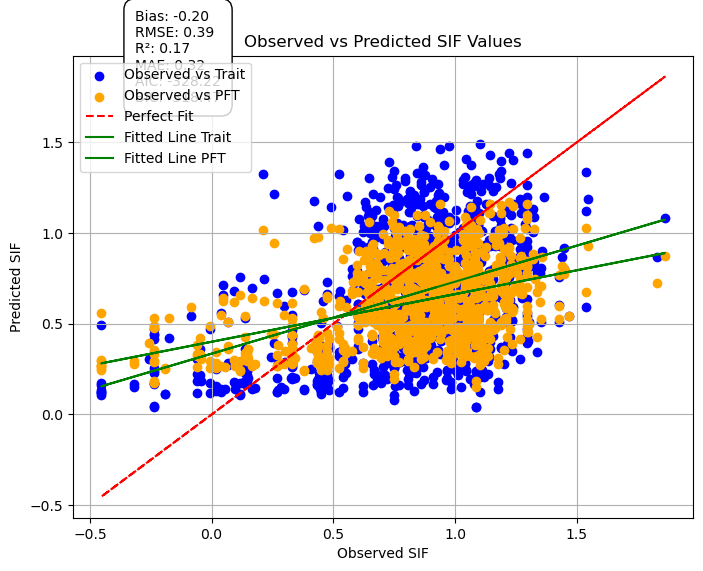

In [23]:
# Calculate mean absolute difference and R^2 score for all accumulated data points
mean_abs_diff_trait = np.mean(np.abs(np.array(predicted_all_trait) - np.array(observed_all_trait)))
mean_abs_diff_pft = np.mean(np.abs(np.array(predicted_all_pft) - np.array(observed_all_pft)))
#r2 = r2_score(np.array(observed_all), np.array(predicted_all))
# Calculate Pearson correlation coefficient
pearson_corr_trait, _ = pearsonr(np.array(observed_all_trait), np.array(predicted_all_trait))
pearson_corr_pft, _ = pearsonr(np.array(observed_all_pft), np.array(predicted_all_pft))

# Calculate R^2
r2_trait = pearson_corr_trait**2
r2_pft = pearson_corr_pft**2


# Create a scatter plot for all accumulated data points
plt.figure(figsize=(8, 6))
plt.scatter(observed_all_trait, predicted_all_trait, color='blue', label='Observed vs Trait')
plt.scatter(observed_all_pft, predicted_all_pft, color='orange', label='Observed vs PFT')
plt.plot(observed_all, observed_all, color='red', linestyle='--', label='Perfect Fit')

# Perform linear regression
slope_trait, intercept_trait, r_value_trait, p_value_trait, std_err_trait = linregress(observed_all_trait, predicted_all_trait)
slope_pft, intercept_pft, r_value_pft, p_value_pft, std_err_pft = linregress(observed_all_pft, predicted_all_pft)


# Assuming observed_all is a list
observed_all_trait = np.array(observed_all_trait)
observed_all_pft = np.array(observed_all_pft)
predicted_all_trait = np.array(predicted_all_trait)
predicted_all_pft = np.array(predicted_all_pft)

# Calculate fitted values using the regression equation
fitted_values_trait = intercept_trait + slope_trait * observed_all_trait
fitted_values_pft = intercept_pft + slope_pft * observed_all_pft

# Calculate MAE, bias, RMSE, and R² trait
mae_trait = mean_absolute_error(observed_all_trait, predicted_all_trait)
bias_trait = np.mean(predicted_all_trait - observed_all_trait)
rmse_trait = np.sqrt(np.mean((predicted_all_trait - observed_all_trait)**2))
r2_trait = r_value_trait**2

# Calculate MAE, bias, RMSE, and R² pft
mae_pft = mean_absolute_error(observed_all_pft, predicted_all_pft)
bias_pft = np.mean(predicted_all_pft - observed_all_pft)
rmse_pft = np.sqrt(np.mean((predicted_all_pft - observed_all_pft)**2))
r2_pft = r_value_pft**2

# Fit the linear regression model using statsmodels for AIC and BIC
X_trait = sm.add_constant(observed_all_trait)  # Add a constant term to the predictor
X_pft = sm.add_constant(observed_all_pft)  # Add a constant term to the predictor
model_trait = sm.OLS(predicted_all_trait, X_trait).fit()
model_pft = sm.OLS(predicted_all_pft, X_pft).fit()

# Get AIC and BIC
aic_trait = model_trait.aic
bic_trait = model_trait.bic

# Get AIC and BIC
aic_pft = model_pft.aic
bic_pft = model_pft.bic

print("TRAIT AIC =", aic_trait, "BIC" ,bic_trait)
print("PFT AIC =", aic_pft, "BIC" ,bic_pft)

# Plot the regression line
plt.plot(observed_all_trait, fitted_values_trait, color='green', label='Fitted Line Trait')
plt.plot(observed_all_pft, fitted_values_pft, color='green', label='Fitted Line PFT')

# Display bias, RMSE, and R² on the plot
plt.text(0.1, 0.9, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}\nAIC: {aic:.2f}\nBIC: {bic:.2f}', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8'))

print(f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}\nAIC: {aic:.2f}\nBIC: {bic:.2f}')

plt.title('Observed vs Predicted SIF Values')
plt.xlabel('Observed SIF')
plt.ylabel('Predicted SIF')
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig(f'pft_scatter_plot_all_trait_and_pft_hr.png')
plt.close()


file.close()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


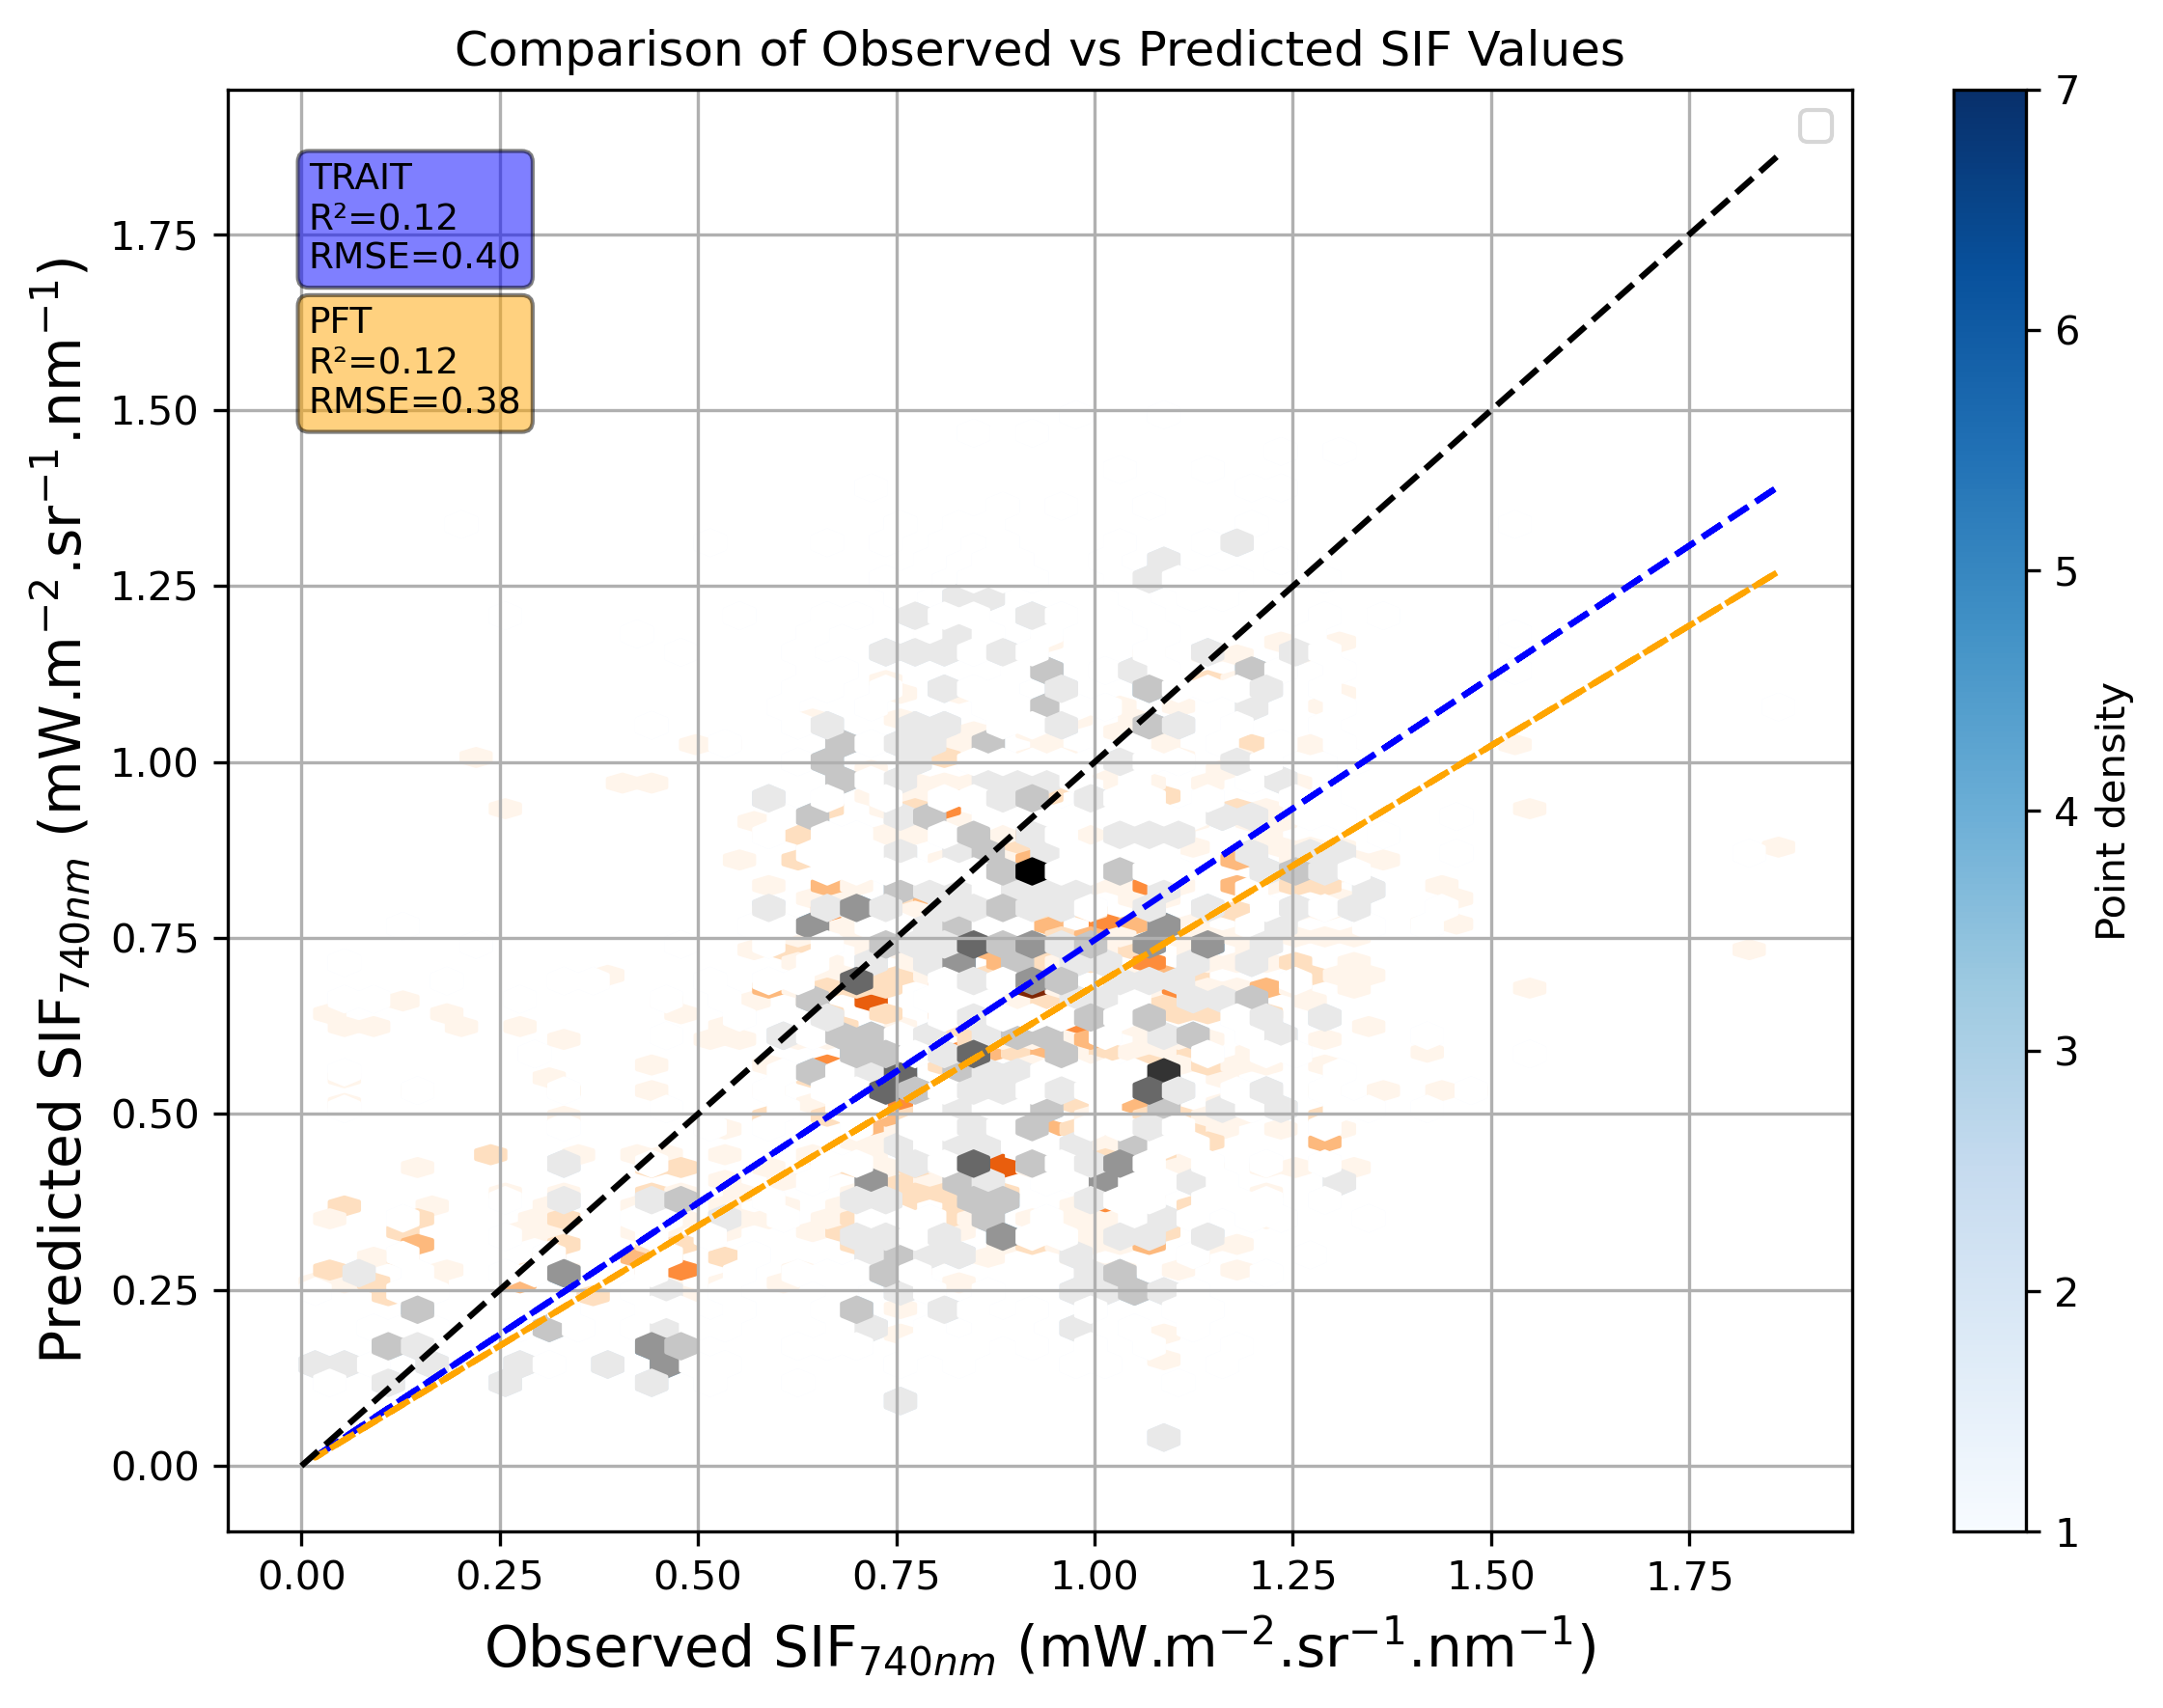

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

# Assuming 'observed_all_trait', 'predicted_all_trait', 'observed_all_pft', 'predicted_all_pft' are defined

# Convert all lists to numpy arrays for calculations
observed_all_trait = np.array(observed_all_trait)
predicted_all_trait = np.array(predicted_all_trait)
observed_all_pft = np.array(observed_all_pft)
predicted_all_pft = np.array(predicted_all_pft)

# Filter out negative values
positive_filter_trait = (observed_all_trait > 0) & (predicted_all_trait > 0)
positive_filter_pft = (observed_all_pft > 0) & (predicted_all_pft > 0)

observed_all_trait = observed_all_trait[positive_filter_trait]
predicted_all_trait = predicted_all_trait[positive_filter_trait]
observed_all_pft = observed_all_pft[positive_filter_pft]
predicted_all_pft = predicted_all_pft[positive_filter_pft]

# Recalculate R^2 and RMSE
r2_trait = pearsonr(observed_all_trait, predicted_all_trait)[0] ** 2
rmse_trait = np.sqrt(mean_squared_error(observed_all_trait, predicted_all_trait))
r2_pft = pearsonr(observed_all_pft, predicted_all_pft)[0] ** 2
rmse_pft = np.sqrt(mean_squared_error(observed_all_pft, predicted_all_pft))

# Perform linear regression for the line of best fit through zero (no intercept)
slope_trait = np.linalg.lstsq(observed_all_trait[:, np.newaxis], predicted_all_trait, rcond=None)[0]
slope_pft = np.linalg.lstsq(observed_all_pft[:, np.newaxis], predicted_all_pft, rcond=None)[0]

# Create the hexbin plot
plt.figure(figsize=(8, 6), dpi=300)  # Specify high resolution for publication quality

# Trait data
hb_trait = plt.hexbin(observed_all_trait, predicted_all_trait, gridsize=50, cmap='Blues',  mincnt=1)
# PFT data
hb_pft = plt.hexbin(observed_all_pft, predicted_all_pft, gridsize=50, cmap='Oranges',  mincnt=1)

hb_color = plt.hexbin(observed_all_trait, predicted_all_trait, gridsize=50, cmap='Greys',  mincnt=1)

# Add colorbar with log scale
cb = plt.colorbar(hb_trait)
cb.set_label('Point density')

# Add the lines of best fit, forcing them through zero
fit_trait = slope_trait * observed_all_trait
fit_pft = slope_pft * observed_all_pft
plt.plot(observed_all_trait, fit_trait, color='blue', linestyle='--')
plt.plot(observed_all_pft, fit_pft, color='orange', linestyle='--')

# Add R^2 and RMSE to the plot for trait
plt.text(0.05, 0.95, f'TRAIT\nR²={r2_trait:.2f}\nRMSE={rmse_trait:.2f}',
         fontsize=9, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='blue', alpha=0.5))

# Add R^2 and RMSE to the plot for PFT
plt.text(0.05, 0.85, f'PFT\nR²={r2_pft:.2f}\nRMSE={rmse_pft:.2f}',
         fontsize=9, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='orange', alpha=0.5))

# Plot 1:1 line
max_val = max(observed_all_trait.max(), observed_all_pft.max())
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')

# Titles and labels with increased font size for axis titles
plt.title('Comparison of Observed vs Predicted SIF Values')
plt.xlabel(r'Observed SIF$_{740nm}$ (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', fontsize=14)
plt.ylabel(r'Predicted SIF$_{740nm}$ (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', fontsize=14)
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Save the plot with a high DPI for publication quality
# plt.savefig('comparison_plot.png', dpi=300)
plt.close()


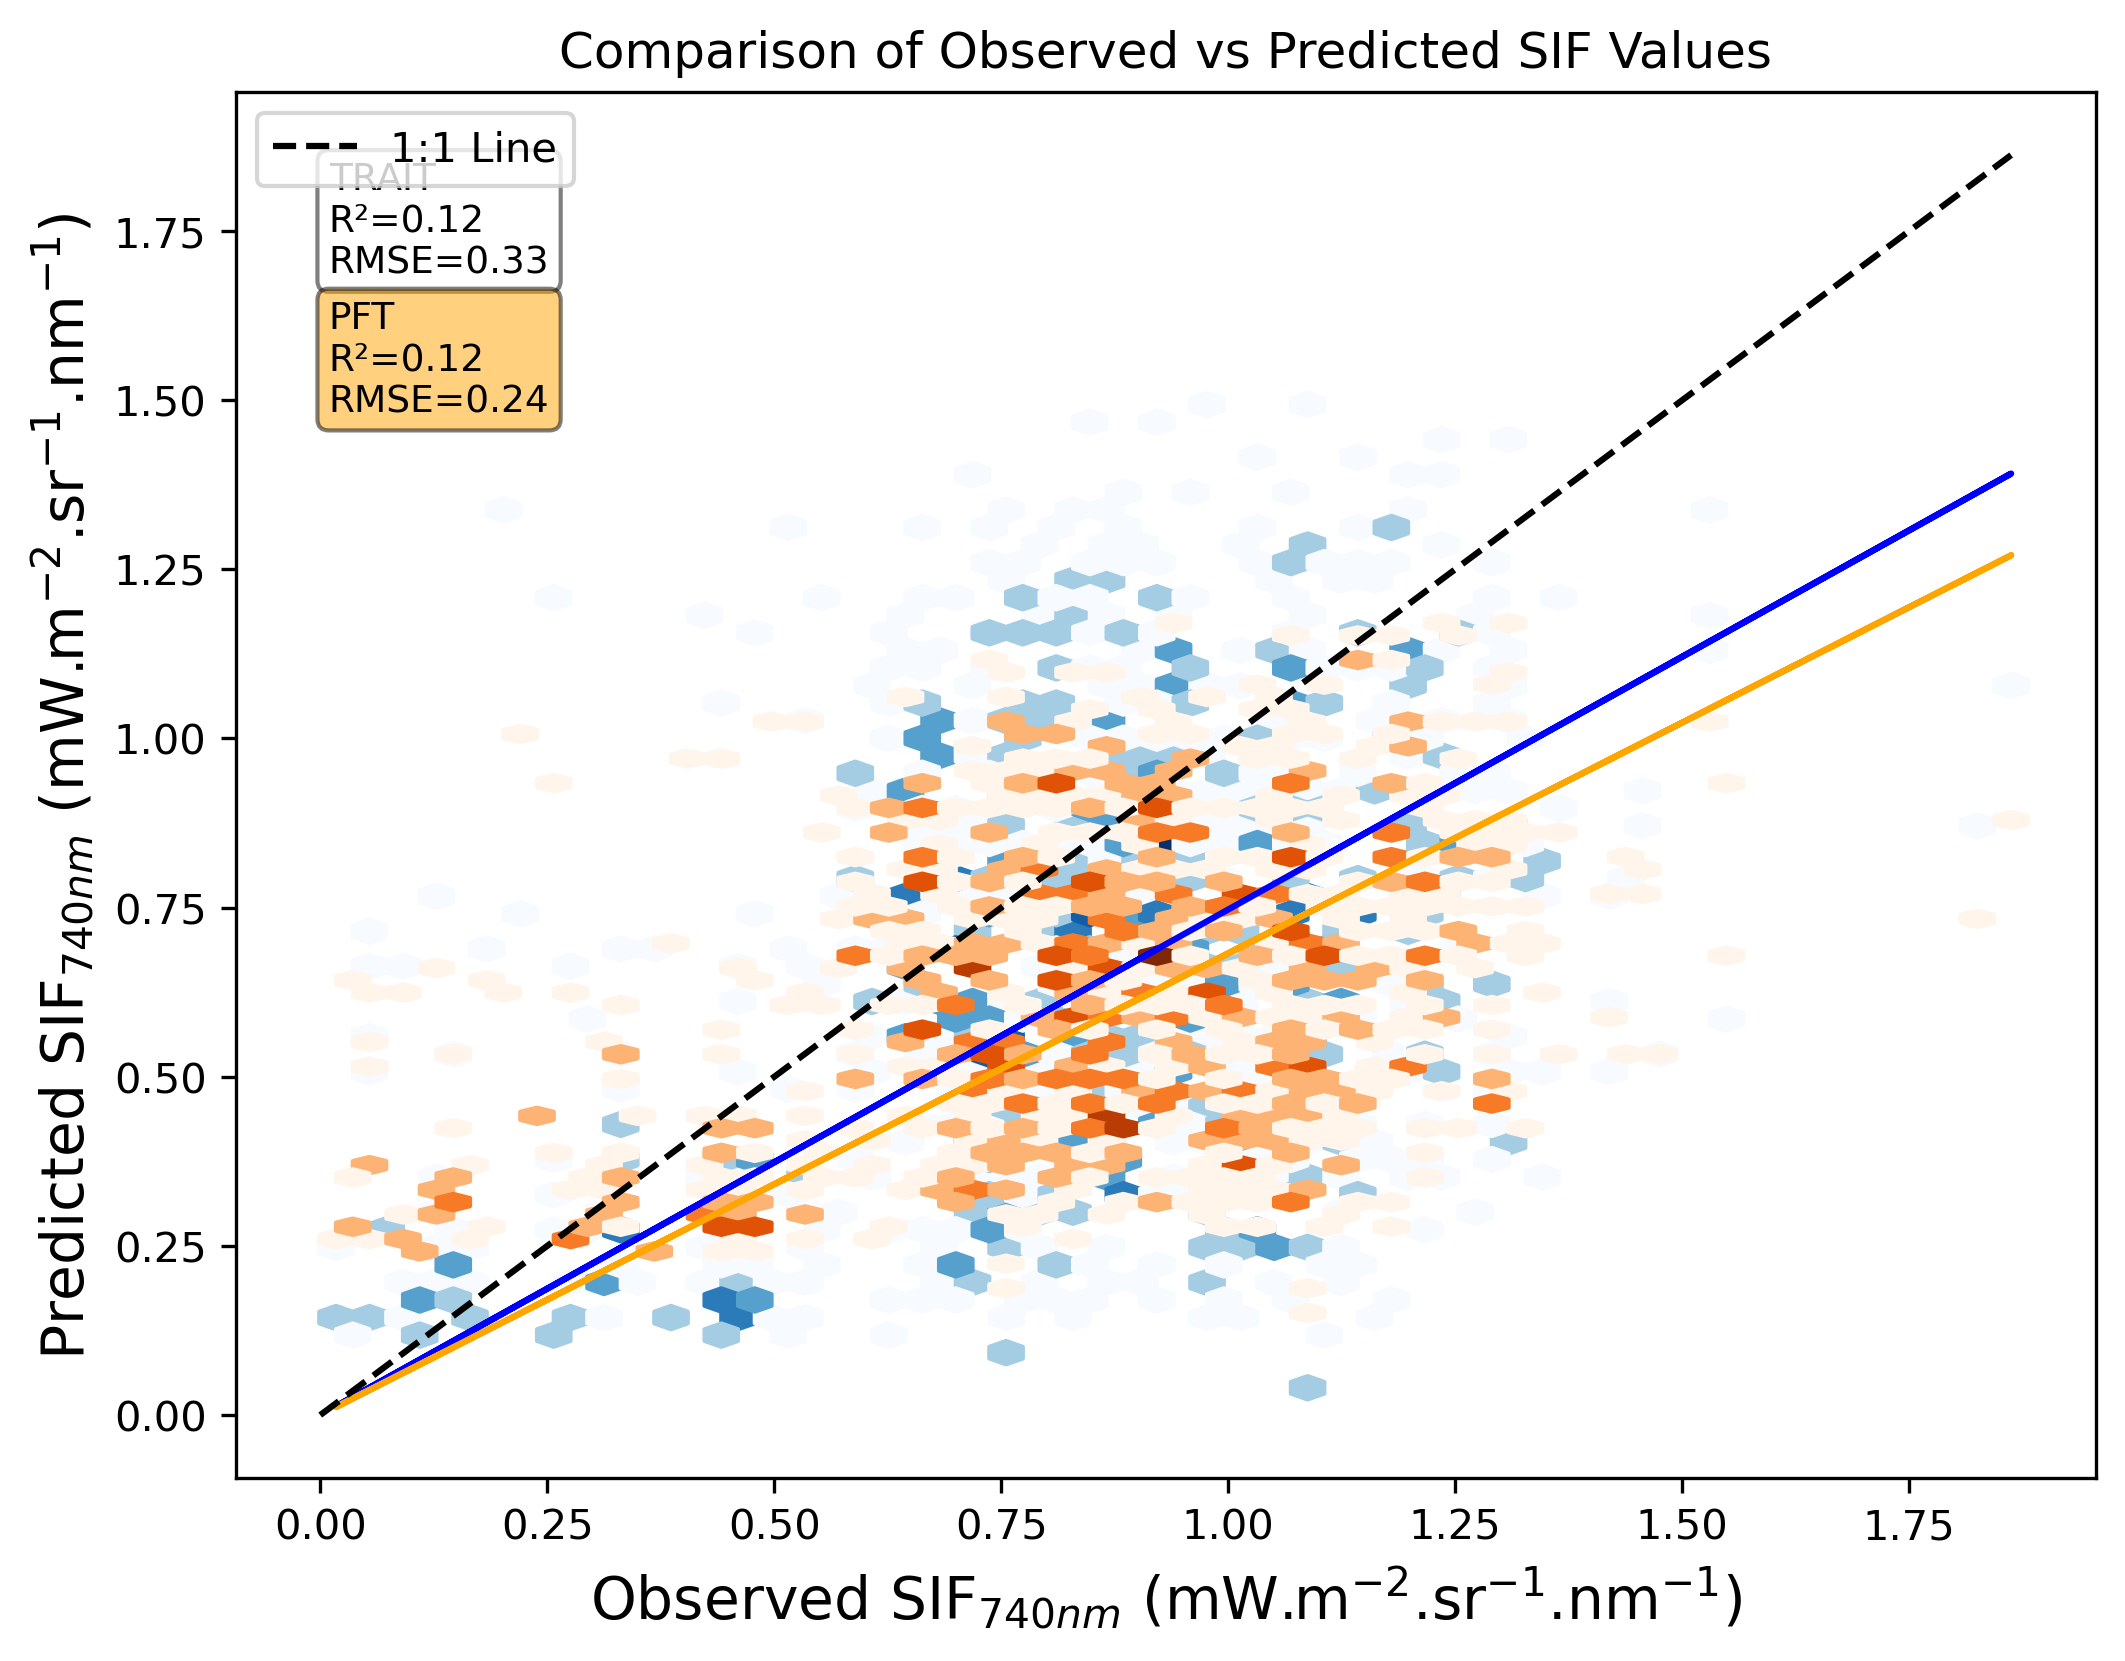

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# Assuming 'observed_all_trait', 'predicted_all_trait', 'observed_all_pft', 'predicted_all_pft' are defined

# Convert all lists to numpy arrays for calculations
observed_all_trait = np.array(observed_all_trait)
predicted_all_trait = np.array(predicted_all_trait)
observed_all_pft = np.array(observed_all_pft)
predicted_all_pft = np.array(predicted_all_pft)

# Filter out negative values and values above 1.75
positive_filter_trait = (observed_all_trait > 0) & (predicted_all_trait > 0) & (predicted_all_trait <= 1.75)
positive_filter_pft = (observed_all_pft > 0) & (predicted_all_pft > 0) & (predicted_all_pft <= 1.75)

observed_all_trait = observed_all_trait[positive_filter_trait]
predicted_all_trait = predicted_all_trait[positive_filter_trait]
observed_all_pft = observed_all_pft[positive_filter_pft]
predicted_all_pft = predicted_all_pft[positive_filter_pft]

# Perform zero-intercept linear regression for the line of best fit
slope_trait = np.linalg.lstsq(observed_all_trait[:, np.newaxis], predicted_all_trait, rcond=None)[0]
slope_pft = np.linalg.lstsq(observed_all_pft[:, np.newaxis], predicted_all_pft, rcond=None)[0]

# Calculate the fits
fit_trait = slope_trait * observed_all_trait
fit_pft = slope_pft * observed_all_pft

# Recalculate R^2 and RMSE using the fits
r2_trait = pearsonr(predicted_all_trait, fit_trait)[0] ** 2
rmse_trait = np.sqrt(mean_squared_error(predicted_all_trait, fit_trait))
r2_pft = pearsonr(predicted_all_pft, fit_pft)[0] ** 2
rmse_pft = np.sqrt(mean_squared_error(predicted_all_pft, fit_pft))

# Create the hexbin plot
plt.figure(figsize=(8, 6), dpi=300)

# Trait data
plt.hexbin(observed_all_trait, predicted_all_trait, gridsize=50, cmap='Blues', bins='log', mincnt=1)
# PFT data
plt.hexbin(observed_all_pft, predicted_all_pft, gridsize=50, cmap='Oranges', bins='log', mincnt=1)

# Add the lines of best fit, forcing them through zero
plt.plot(observed_all_trait, fit_trait, color='blue', linestyle='-')
plt.plot(observed_all_pft, fit_pft, color='orange', linestyle='-')

# Add R^2 and RMSE to the plot for trait
plt.text(0.05, 0.95, f'TRAIT\nR²={r2_trait:.2f}\nRMSE={rmse_trait:.2f}',
         fontsize=9, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Add R^2 and RMSE to the plot for PFT
plt.text(0.05, 0.85, f'PFT\nR²={r2_pft:.2f}\nRMSE={rmse_pft:.2f}',
         fontsize=9, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='orange', alpha=0.5))

# Plot 1:1 line
max_val = max(observed_all_trait.max(), observed_all_pft.max())
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--', label='1:1 Line')

# Titles and labels with increased font size for axis titles
plt.title('Comparison of Observed vs Predicted SIF Values')
plt.xlabel(r'Observed SIF$_{740nm}$ (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', fontsize=14)
plt.ylabel(r'Predicted SIF$_{740nm}$ (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', fontsize=14)
plt.legend()


## PLOT for pub

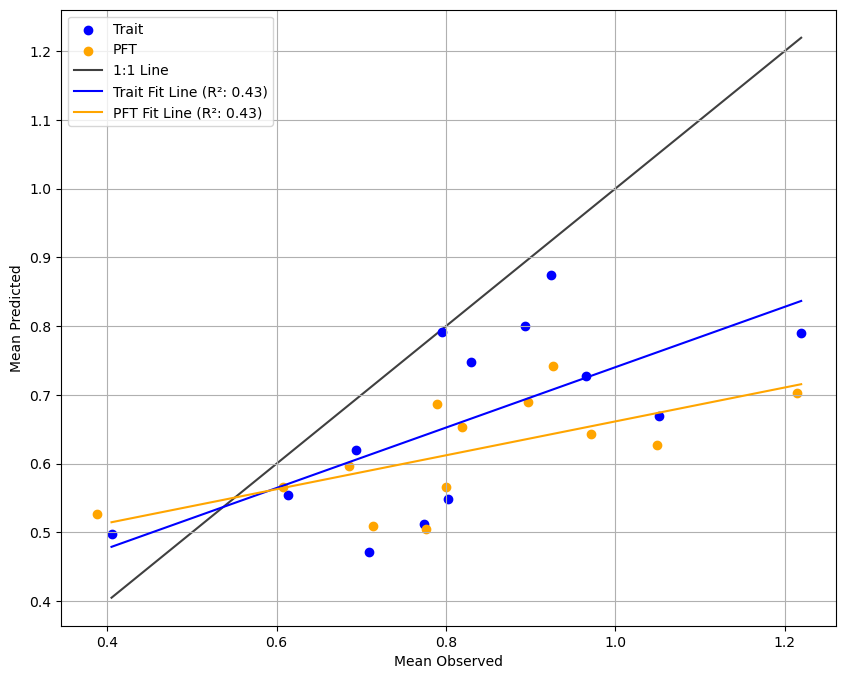

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming file paths
file_path_trait = 'trait_statistics_lr_jmax.txt'
file_path_pft = 'pft_statistics_lr_jmax.txt'

# Custom names based on your provided indices if misalignment exists
column_names = ['Date', 'Mean Observed', 'Std Observed', 'CI95 Observed Low', 'CI95 Observed High',
                'Mean Predicted', 'Std Predicted', 'CI95 Predicted Low', 'CI95 Predicted High', 'Bias', 'RMSE', 'R2']

# Reading the data
data_trait = pd.read_csv(file_path_trait, delim_whitespace=True, header=None, names=column_names, skiprows=1)
data_pft = pd.read_csv(file_path_pft, delim_whitespace=True, header=None, names=column_names, skiprows=1)

# Convert CI95 from low-high string to a tuple
def parse_ci95(low, high):
    return (low, high)

data_trait['CI95 Observed'] = data_trait.apply(lambda x: parse_ci95(x['CI95 Observed Low'], x['CI95 Observed High']), axis=1)
data_trait['CI95 Predicted'] = data_trait.apply(lambda x: parse_ci95(x['CI95 Predicted Low'], x['CI95 Predicted High']), axis=1)
data_pft['CI95 Observed'] = data_pft.apply(lambda x: parse_ci95(x['CI95 Observed Low'], x['CI95 Observed High']), axis=1)
data_pft['CI95 Predicted'] = data_pft.apply(lambda x: parse_ci95(x['CI95 Predicted Low'], x['CI95 Predicted High']), axis=1)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(data_trait['Mean Observed'], data_trait['Mean Predicted'], color='blue', label='Trait')
plt.scatter(data_pft['Mean Observed'], data_pft['Mean Predicted'], color='orange', label='PFT')

# Plot 1:1 line
lims = [np.min([data_trait['Mean Observed'].min(), data_trait['Mean Predicted'].min(), data_pft['Mean Predicted'].min()]),
        np.max([data_trait['Mean Observed'].max(), data_trait['Mean Predicted'].max(), data_pft['Mean Predicted'].max()])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label='1:1 Line')

# Adding regression line and legend
for label, color, data in [('Trait', 'blue', data_trait), ('PFT', 'orange', data_pft)]:
    slope, intercept, r_value, _, _ = linregress(data['Mean Observed'], data['Mean Predicted'])
    plt.plot(lims, [slope * x + intercept for x in lims], color=color, label=f'{label} Fit Line (R²: {r_value**2:.2f})')

plt.xlabel('Mean Observed')
plt.ylabel('Mean Predicted')
plt.legend()
plt.grid(True)
plt.show()


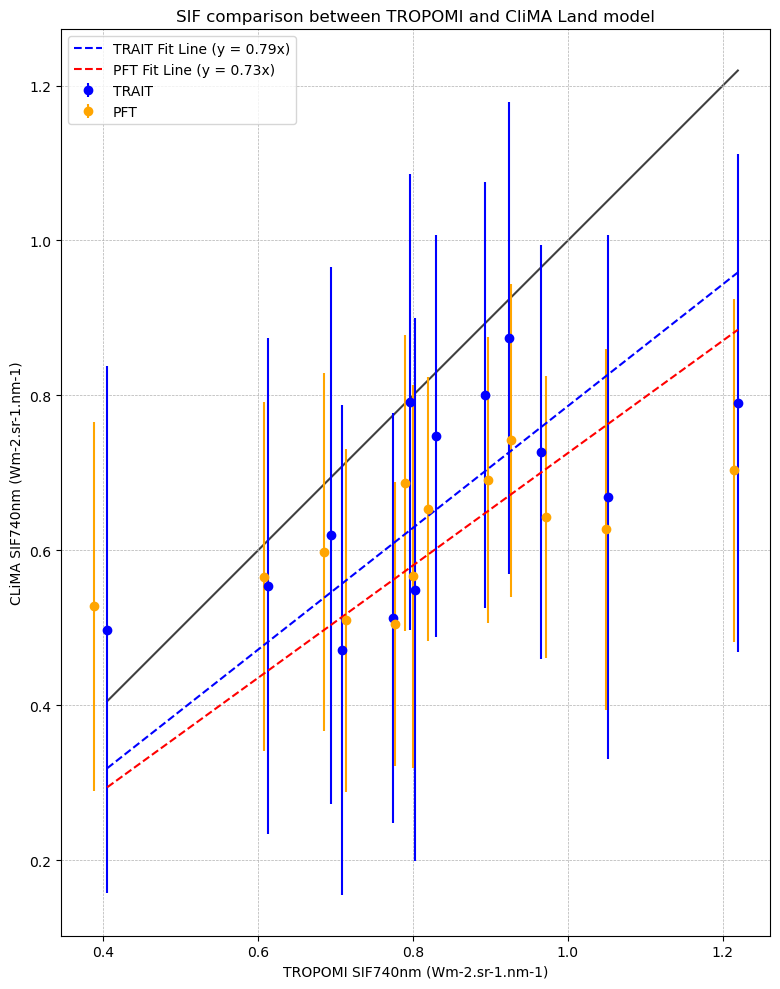

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assuming file paths are correct and the same structure as the working script
file_path_trait = 'trait_statistics_lr_jmax.txt'
file_path_pft = 'pft_statistics_lr_jmax.txt'

# Use the same column names as in the working script for consistency
column_names = ['Date', 'Mean Observed', 'Std Observed', 'CI95 Observed Low', 'CI95 Observed High',
                'Mean Predicted', 'Std Predicted', 'CI95 Predicted Low', 'CI95 Predicted High', 'Bias', 'RMSE', 'R2']

# Read the data from the files
data_trait = pd.read_csv(file_path_trait, delim_whitespace=True, names=column_names, header=None, skiprows=1)
data_pft = pd.read_csv(file_path_pft, delim_whitespace=True, names=column_names, header=None, skiprows=1)

# Convert CI95 from low-high string to a tuple
def parse_ci95(low, high):
    return (low, high)

data_trait['CI95 Observed'] = data_trait.apply(lambda x: parse_ci95(x['CI95 Observed Low'], x['CI95 Observed High']), axis=1)
data_trait['CI95 Predicted'] = data_trait.apply(lambda x: parse_ci95(x['CI95 Predicted Low'], x['CI95 Predicted High']), axis=1)
data_pft['CI95 Observed'] = data_pft.apply(lambda x: parse_ci95(x['CI95 Observed Low'], x['CI95 Observed High']), axis=1)
data_pft['CI95 Predicted'] = data_pft.apply(lambda x: parse_ci95(x['CI95 Predicted Low'], x['CI95 Predicted High']), axis=1)

# Function for linear regression through zero
def linear_zero_intercept(x, slope):
    return slope * x

# Fit the data to the linear function through zero
params_trait, _ = curve_fit(linear_zero_intercept, data_trait['Mean Observed'], data_trait['Mean Predicted'])
params_pft, _ = curve_fit(linear_zero_intercept, data_pft['Mean Observed'], data_pft['Mean Predicted'])

# Plot settings
plt.figure(figsize=(8, 10))

# Error bars: Use standard deviation for error bars
plt.errorbar(data_trait['Mean Observed'], data_trait['Mean Predicted'], 
             yerr=data_trait['Std Predicted'], fmt='o', color='blue', label='TRAIT')
plt.errorbar(data_pft['Mean Observed'], data_pft['Mean Predicted'], 
             yerr=data_pft['Std Predicted'], fmt='o', color='orange', label='PFT')

# 1:1 line and fitted lines
lims = [
    np.min([data_trait['Mean Observed'].min(), data_trait['Mean Predicted'].min(), data_pft['Mean Predicted'].min()]),
    np.max([data_trait['Mean Observed'].max(), data_trait['Mean Predicted'].max(), data_pft['Mean Predicted'].max()])
]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)  # 1:1 line
plt.plot(lims, [params_trait[0] * x for x in lims], 'b--', label=f'TRAIT Fit Line (y = {params_trait[0]:.2f}x)')
plt.plot(lims, [params_pft[0] * x for x in lims], 'r--', label=f'PFT Fit Line (y = {params_pft[0]:.2f}x)')

# Enhancements for publication quality
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()


plt.xlabel('TROPOMI SIF740nm (Wm-2.sr-1.nm-1)')
plt.ylabel('CLiMA SIF740nm (Wm-2.sr-1.nm-1)')
plt.title('SIF comparison between TROPOMI and CliMA Land model')
plt.tight_layout()

# Save the plot with a high DPI for publication quality
# plt.savefig('/mnt/data/output_plot.png', dpi=300)

plt.show()


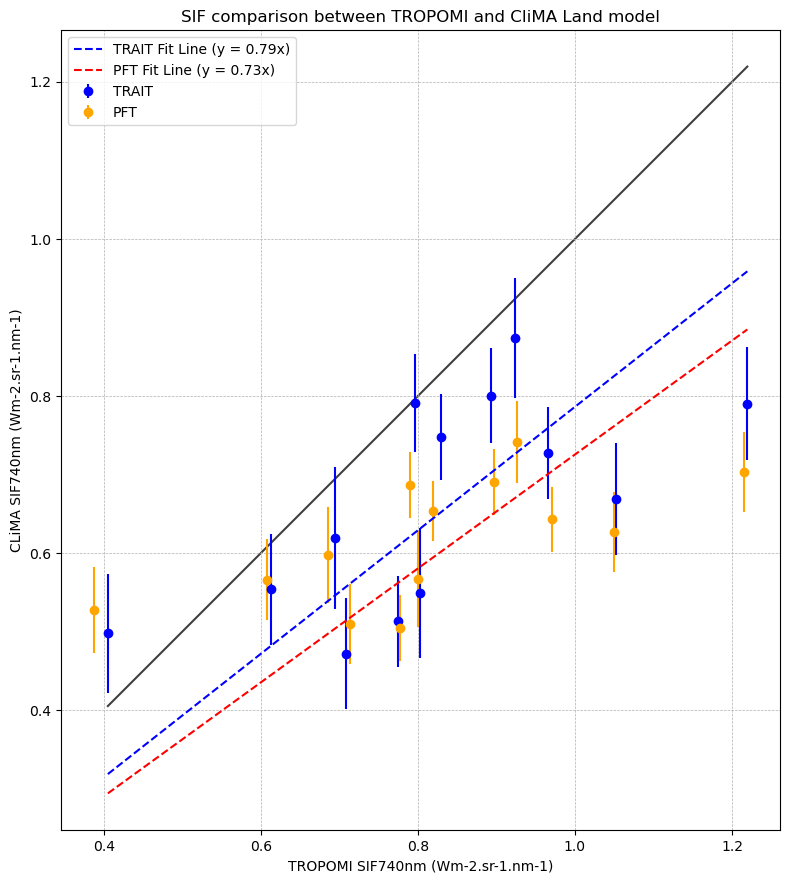

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assuming file paths are correct and the same structure as the working script
file_path_trait = 'trait_statistics_lr_jmax.txt'
file_path_pft = 'pft_statistics_lr_jmax.txt'

# Use the same column names as in the working script for consistency
column_names = ['Date', 'Mean Observed', 'Std Observed', 'CI95 Observed Low', 'CI95 Observed High',
                'Mean Predicted', 'Std Predicted', 'CI95 Predicted Low', 'CI95 Predicted High', 'Bias', 'RMSE', 'R2']

# Read the data from the files
data_trait = pd.read_csv(file_path_trait, delim_whitespace=True, names=column_names, header=None, skiprows=1)
data_pft = pd.read_csv(file_path_pft, delim_whitespace=True, names=column_names, header=None, skiprows=1)

# Calculate the CI95 error bars as differences from the mean
data_trait['CI95 Predicted Error Lower'] = data_trait['Mean Predicted'] - data_trait['CI95 Predicted Low']
data_trait['CI95 Predicted Error Upper'] = data_trait['CI95 Predicted High'] - data_trait['Mean Predicted']
data_pft['CI95 Predicted Error Lower'] = data_pft['Mean Predicted'] - data_pft['CI95 Predicted Low']
data_pft['CI95 Predicted Error Upper'] = data_pft['CI95 Predicted High'] - data_pft['Mean Predicted']

# Function for linear regression through zero
def linear_zero_intercept(x, slope):
    return slope * x

# Fit the data to the linear function through zero
params_trait, _ = curve_fit(linear_zero_intercept, data_trait['Mean Observed'], data_trait['Mean Predicted'])
params_pft, _ = curve_fit(linear_zero_intercept, data_pft['Mean Observed'], data_pft['Mean Predicted'])

# Plot settings
plt.figure(figsize=(8, 10))

# Error bars: Use CI95 for error bars
plt.errorbar(data_trait['Mean Observed'], data_trait['Mean Predicted'], 
             yerr=[data_trait['CI95 Predicted Error Lower'], data_trait['CI95 Predicted Error Upper']], fmt='o', color='blue', label='TRAIT')
plt.errorbar(data_pft['Mean Observed'], data_pft['Mean Predicted'], 
             yerr=[data_pft['CI95 Predicted Error Lower'], data_pft['CI95 Predicted Error Upper']], fmt='o', color='orange', label='PFT')

# 1:1 line and fitted lines
lims = [
    np.min([data_trait['Mean Observed'].min(), data_trait['Mean Predicted'].min(), data_pft['Mean Predicted'].min()]),
    np.max([data_trait['Mean Observed'].max(), data_trait['Mean Predicted'].max(), data_pft['Mean Predicted'].max()])
]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)  # 1:1 line
plt.plot(lims, [params_trait[0] * x for x in lims], 'b--', label=f'TRAIT Fit Line (y = {params_trait[0]:.2f}x)')
plt.plot(lims, [params_pft[0] * x for x in lims], 'r--', label=f'PFT Fit Line (y = {params_pft[0]:.2f}x)')

# Enhancements for publication quality
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.xlabel('TROPOMI SIF740nm (Wm-2.sr-1.nm-1)')
plt.ylabel('CLiMA SIF740nm (Wm-2.sr-1.nm-1)')
plt.title('SIF comparison between TROPOMI and CliMA Land model')
plt.tight_layout()

# Save the plot with a high DPI for publication quality
# plt.savefig('/mnt/data/output_plot.png', dpi=300)

plt.show()


/home/renatob/miniconda3/envs/shape_clip/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/renatob/miniconda3/envs/shape_clip/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/renatob/miniconda3/envs/shape_clip/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/renatob/miniconda3/envs/shape_clip/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future vers

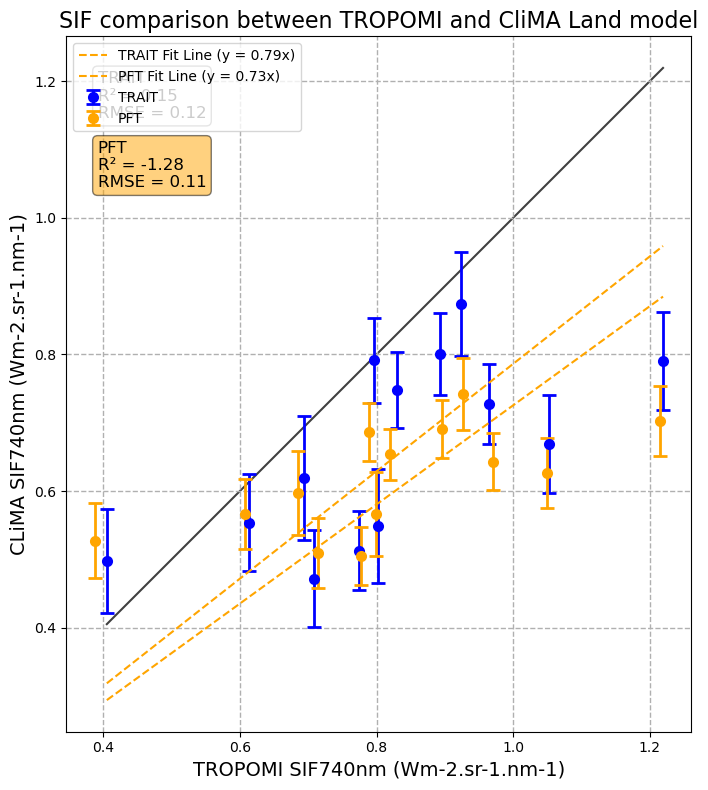

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

# Reading data
file_path_trait = 'trait_statistics_lr_jmax.txt'
file_path_pft = 'pft_statistics_lr_jmax.txt'
column_names = ['Date', 'Mean Observed', 'Std Observed', 'CI95 Observed Low', 'CI95 Observed High',
                'Mean Predicted', 'Std Predicted', 'CI95 Predicted Low', 'CI95 Predicted High', 'Bias', 'RMSE', 'R2']

data_trait = pd.read_csv(file_path_trait, delim_whitespace=True, names=column_names, header=None, skiprows=1)
data_pft = pd.read_csv(file_path_pft, delim_whitespace=True, names=column_names, header=None, skiprows=1)

# Compute the CI95 error margins
data_trait['CI95 Predicted Error Lower'] = data_trait['Mean Predicted'] - data_trait['CI95 Predicted Low']
data_trait['CI95 Predicted Error Upper'] = data_trait['CI95 Predicted High'] - data_trait['Mean Predicted']
data_pft['CI95 Predicted Error Lower'] = data_pft['Mean Predicted'] - data_pft['CI95 Predicted Low']
data_pft['CI95 Predicted Error Upper'] = data_pft['CI95 Predicted High'] - data_pft['Mean Predicted']

# Linear regression function without intercept
def linear_zero_intercept(x, slope):
    return slope * x

# Fit data
params_trait, _ = curve_fit(linear_zero_intercept, data_trait['Mean Observed'], data_trait['Mean Predicted'])
params_pft, _ = curve_fit(linear_zero_intercept, data_pft['Mean Observed'], data_pft['Mean Predicted'])

# Calculating new RMSE and R2
predicted_trait_fit = params_trait[0] * data_trait['Mean Observed']
predicted_pft_fit = params_pft[0] * data_pft['Mean Observed']

rmse_trait = np.sqrt(mean_squared_error(data_trait['Mean Predicted'], predicted_trait_fit))
r2_trait = r2_score(data_trait['Mean Predicted'], predicted_trait_fit)

rmse_pft = np.sqrt(mean_squared_error(data_pft['Mean Predicted'], predicted_pft_fit))
r2_pft = r2_score(data_pft['Mean Predicted'], predicted_pft_fit)

# Plotting
plt.figure(figsize=(10, 8))
plt.errorbar(data_trait['Mean Observed'], data_trait['Mean Predicted'],
             yerr=[data_trait['CI95 Predicted Error Lower'].tolist(), data_trait['CI95 Predicted Error Upper'].tolist()],
             fmt='o', color='blue', label='TRAIT', capsize=5, capthick=2, elinewidth=2, markeredgewidth=2)
plt.errorbar(data_pft['Mean Observed'], data_pft['Mean Predicted'],
             yerr=[data_pft['CI95 Predicted Error Lower'].tolist(), data_pft['CI95 Predicted Error Upper'].tolist()],
             fmt='o', color='orange', label='PFT', capsize=5, capthick=2, elinewidth=2, markeredgewidth=2)

lims = [np.min([data_trait['Mean Observed'].min(), data_trait['Mean Predicted'].min(), data_pft['Mean Predicted'].min()]),
        np.max([data_trait['Mean Observed'].max(), data_trait['Mean Predicted'].max(), data_pft['Mean Predicted'].max()])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.plot(lims, [params_trait[0] * x for x in lims], '--', color='orange', label=f'TRAIT Fit Line (y = {params_trait[0]:.2f}x)')
plt.plot(lims, [params_pft[0] * x for x in lims], '--', color='orange', label=f'PFT Fit Line (y = {params_pft[0]:.2f}x)')

# Annotations for new RMSE and R²
plt.text(0.05, 0.95, f'TRAIT\nR² = {r2_trait:.2f}\nRMSE = {rmse_trait:.2f}', fontsize=12, verticalalignment='top',
         transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.text(0.05, 0.85, f'PFT\nR² = {r2_pft:.2f}\nRMSE = {rmse_pft:.2f}', fontsize=12, verticalalignment='top',
         transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='orange', alpha=0.5))

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, which='both', linestyle='--', linewidth=1)
plt.legend()
plt.xlabel('TROPOMI SIF740nm (Wm-2.sr-1.nm-1)', fontsize=14)
plt.ylabel('CLiMA SIF740nm (Wm-2.sr-1.nm-1)', fontsize=14)
plt.title('SIF comparison between TROPOMI and CliMA Land model', fontsize=16)
plt.tight_layout()

plt.show()
